Changelog for Titanic v5:
- Fare divided by ticket_count
- Imputed Age based on Title & Pclass(Master = young, Mr = older etc.)
- Put Age in 4 bins, Fare in 5 bins using qcut
- Added Family_Survival feature via identical Last_Name and Ticket
- Used GridSearchCV and RandomForest

### Titanic Dataset Analysis for Kaggle

In this classic Kaggle challenge, we try to predict survival on the Titanic based on features of the passengers. 

First,let's import some necessary functions:

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Helper Functions

In [100]:
def plot_subplots(feature, data):
    fx, axes = plt.subplots(2,1,figsize=(15,10))
    axes[0].set_title(f"{feature} vs Frequency")
    axes[1].set_title(f"{feature} vs Survival")
    fig_title1 = sns.countplot(data = data, x=feature, ax=axes[0])
    fig_title2 = sns.countplot(data = data, x=feature, hue='Survived', ax=axes[1])
    
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

Get Titanic DataSet, group together for easy data cleaning

In [101]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

full = train.append(test, sort=False)

titanic = full.iloc[0:891,:]
full.shape

(1309, 12)

In [102]:
full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

**VARIABLE DESCRIPTIONS:**

We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:


**Variable Description**

 - Survived: Survived (1) or died (0)
 - Pclass: Passenger's class (1,2,3)
 - Name: Passenger's name - includes Title of Mr/Miss/Captain etc.
 - Sex: Passenger's sex 
 - Age: Passenger's age
 - SibSp: Number of siblings/spouses aboard
 - Parch: Number of parents/children aboard
 - Ticket: Ticket number
 - Fare: Fare - numerical amount
 - Cabin: Cabin - denoted by letter
 - Embarked: Port of embarkation

[More information on the Kaggle site](https://www.kaggle.com/c/titanic/data)

From the Kaggle site description, we are told that "Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class." Thus, we will make sure to keep an eye on any variables that identify these groups and include them in the final data analysis.

First, let's note down the missing data. We can see that Age and Cabin are the main issues for this dataset. We'll keep that in mind and look for ways to deal with them as we explore the dataset

In [103]:
full.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

##### Let's first work on creating a Title category from Name. We can seperate the passengers by their titles by extracting from the Name column.

In [104]:
full.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [105]:
full['Title'] = full['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])

In [106]:
full.Title.sample(10)

808      Mr.
588      Mr.
160    Miss.
482      Mr.
247      Mr.
779     Mrs.
348      Mr.
500      Mr.
313      Mr.
196      Mr.
Name: Title, dtype: object

In [107]:
full.Title.unique().tolist()

['Mr.',
 'Mrs.',
 'Miss.',
 'Master.',
 'Don.',
 'Rev.',
 'Dr.',
 'Mme.',
 'Ms.',
 'Major.',
 'Lady.',
 'Sir.',
 'Mlle.',
 'Col.',
 'Capt.',
 'the',
 'Jonkheer.',
 'Dona.']

By plotting against survival with our helper function, we can see that Title will be a useful predictor of survival as Mr. died a lot more and Mrs./Miss./Master. survived better on average.

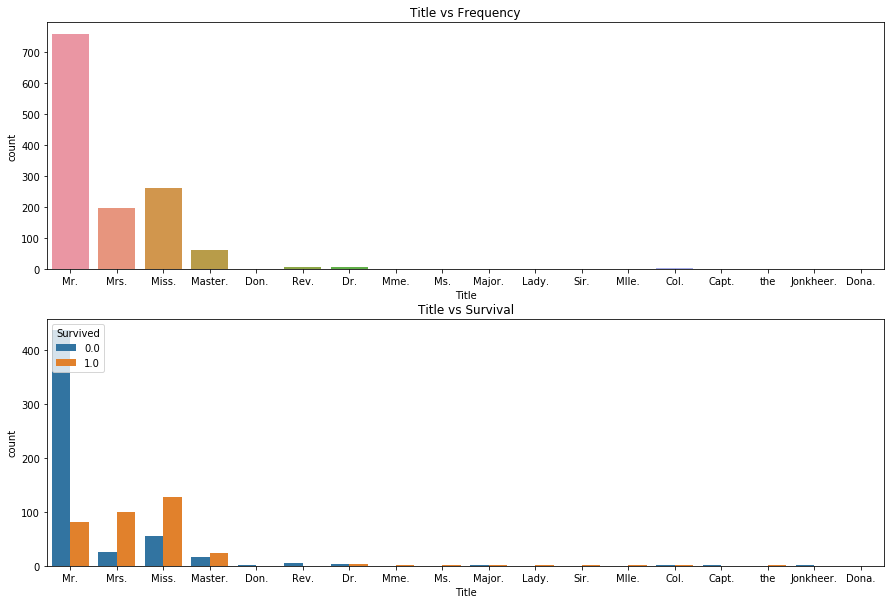

In [108]:
plot_subplots('Title', full)

What is the title 'the'? Let's fix that error.

In [109]:
full.loc[full.Title=='the']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,the


In [110]:
full.iloc[759,-1] = "Countess"

In [111]:
full.iloc[759,:]

PassengerId                                                  760
Survived                                                       1
Pclass                                                         1
Name           Rothes, the Countess. of (Lucy Noel Martha Dye...
Sex                                                       female
Age                                                           33
SibSp                                                          0
Parch                                                          0
Ticket                                                    110152
Fare                                                        86.5
Cabin                                                        B77
Embarked                                                       S
Title                                                   Countess
Name: 759, dtype: object

By looking at a boxplot of Title vs Age, we can conclude that Title is a good variable to use to deal with the missing Age data. We will use it to impute Age later on.

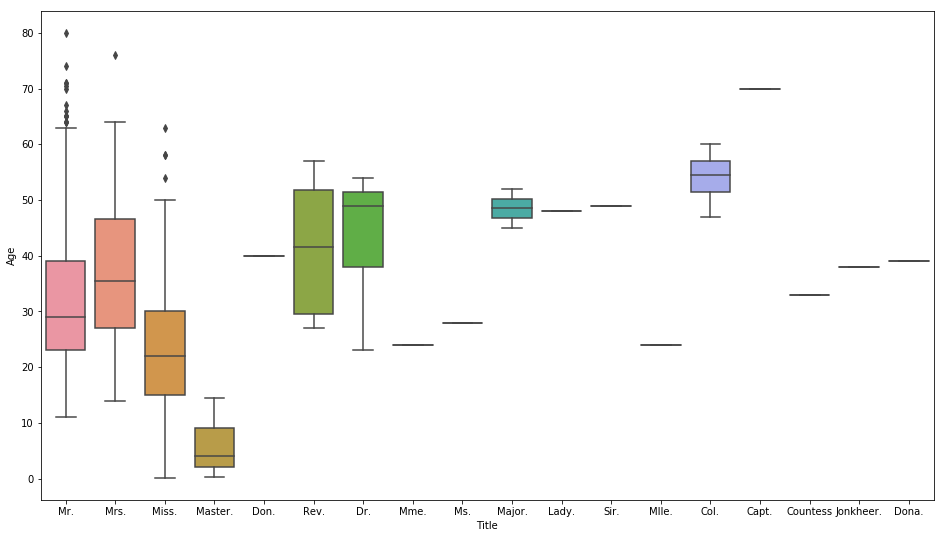

In [112]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.boxplot(x='Title', y='Age', data=full)

In [113]:
full.groupby("Title").Age.describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Capt.,1.0,70.000000,NaN,70.00,70.00,70.0,70.00,70.0
Col.,4.0,54.000000,5.477226,47.00,51.50,54.5,57.00,60.0
Countess,1.0,33.000000,NaN,33.00,33.00,33.0,33.00,33.0
Don.,1.0,40.000000,NaN,40.00,40.00,40.0,40.00,40.0
Dona.,1.0,39.000000,NaN,39.00,39.00,39.0,39.00,39.0
Dr.,7.0,43.571429,11.731115,23.00,38.00,49.0,51.50,54.0
Jonkheer.,1.0,38.000000,NaN,38.00,38.00,38.0,38.00,38.0
Lady.,1.0,48.000000,NaN,48.00,48.00,48.0,48.00,48.0
Major.,2.0,48.500000,4.949747,45.00,46.75,48.5,50.25,52.0


In [114]:
full.groupby("Title").Survived.describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Capt.,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Col.,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0
Countess,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
Don.,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Dona.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dr.,7.0,0.428571,0.534522,0.0,0.00,0.0,1.00,1.0
Jonkheer.,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Lady.,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
Major.,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0


We can use a dictionary to map the rare titles into one:

In [115]:
full.Title.value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Dr.            8
Rev.           8
Col.           4
Mlle.          2
Ms.            2
Major.         2
Don.           1
Capt.          1
Dona.          1
Sir.           1
Mme.           1
Jonkheer.      1
Lady.          1
Countess       1
Name: Title, dtype: int64

In [116]:
Title_Dictionary = {
                    "Mme.":        "Mrs",
                    "Mlle.":       "Mrs",
                    "Ms.":         "Mrs",
                    "Mr." :        "Mr",
                    "Mrs." :       "Mrs",
                    "Miss." :      "Mrs",
                    "Master.":     "Master",
                    "Countess":    "Lady",
                    "Dona.":       "Lady",
                    "Lady.":       "Lady"
                    }

In [117]:
Mapped_titles = full.Title.map(Title_Dictionary)

In [118]:
Mapped_titles.fillna("Rare", inplace=True)

In [119]:
full['Titles_mapped'] = Mapped_titles

In [120]:
full.Titles_mapped.value_counts()

Mr        757
Mrs       462
Master     61
Rare       26
Lady        3
Name: Titles_mapped, dtype: int64

In [121]:
full.Titles_mapped.unique()

array(['Mr', 'Mrs', 'Master', 'Rare', 'Lady'], dtype=object)

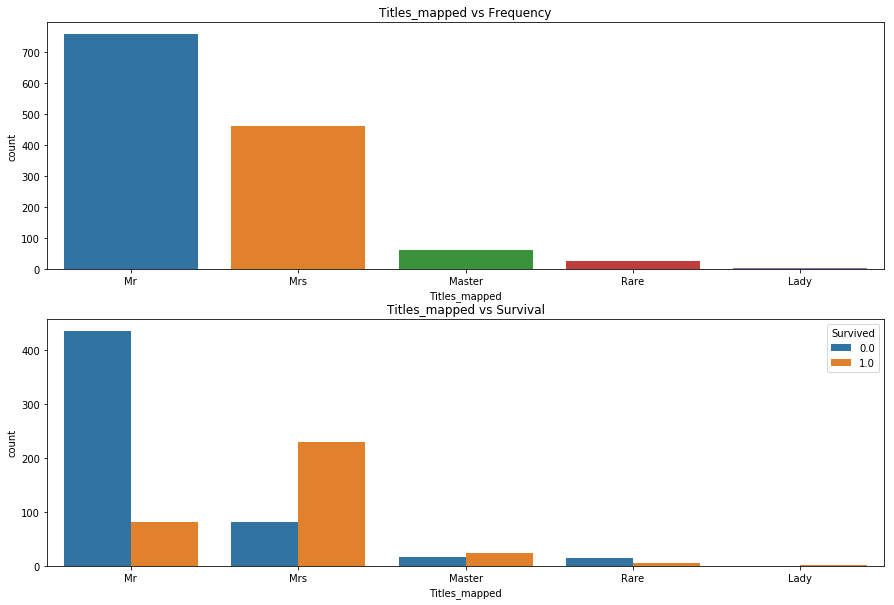

In [122]:
plot_subplots('Titles_mapped', full)

In [123]:
target_columns = []
target_columns.append('Titles_mapped')

For the Ticket variable, we can observe an interesting phenomenon - duplicate tickets!

In [124]:
Ticket = pd.DataFrame(full.Ticket)

In [125]:
Ticket.sample(10)

,Ticket
809,113806
376,C 7077
533,2668
497,C.A. 6212
93,C.A. 2315
359,349910
126,350045
509,1601
495,2627
366,110813


In [126]:
Ticket.Ticket.value_counts()

CA. 2343              11
1601                   8
CA 2144                8
S.O.C. 14879           7
347082                 7
PC 17608               7
347077                 7
3101295                7
19950                  6
113781                 6
347088                 6
382652                 6
4133                   5
W./C. 6608             5
16966                  5
113503                 5
PC 17757               5
349909                 5
220845                 5
24160                  4
12749                  4
W./C. 6607             4
230136                 4
PC 17760               4
36928                  4
C.A. 33112             4
C.A. 2315              4
113760                 4
SC/Paris 2123          4
2666                   4
                      ..
STON/O 2. 3101268      1
364512                 1
36209                  1
PC 17601               1
C.A. 29566             1
STON/O2. 3101282       1
SOTON/O.Q. 3101308     1
349208                 1
237734                 1


### Add column to identify multiple ticket holders

In [127]:
Ticket['Count'] = Ticket.groupby('Ticket')['Ticket'].transform('count')

In [128]:
Ticket.sample(10)

,Ticket,Count
96,19877,3
33,C.A. 24579,1
272,250644,2
292,SC/Paris 2163,1
378,680,1
502,330909,1
678,CA 2144,8
725,315094,1
99,A./5. 3338,1
626,219533,1


In [129]:
full['Ticket_Count'] = Ticket.Count

In [130]:
full.Ticket_Count.head()

0    1
1    2
2    1
3    2
4    1
Name: Ticket_Count, dtype: int64

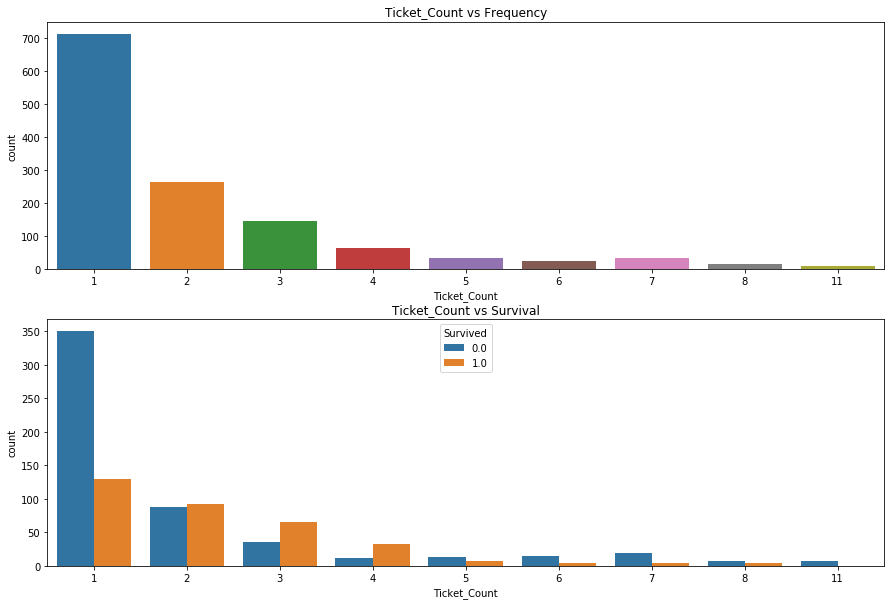

In [131]:
plot_subplots('Ticket_Count', full)

### Seems like Single-ticket holders will more likely die alone... Let's keept this variable!

In [132]:
target_columns.append('Ticket_Count')

Let's look at the other missing data - Cabin

In [133]:
full.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
Title               0
Titles_mapped       0
Ticket_Count        0
dtype: int64

In [134]:
cabin = pd.DataFrame()

In [135]:
cabin['Cabin'] = full.Cabin

In [136]:
cabin.Cabin.value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
C78                4
D                  4
C22 C26            4
F33                4
F4                 4
B96 B98            4
F2                 4
C101               3
B58 B60            3
A34                3
E34                3
E101               3
B51 B53 B55        3
E24                2
C125               2
D17                2
D37                2
B45                2
C31                2
E46                2
C65                2
C106               2
B35                2
E44                2
C52                2
C55 C57            2
B20                2
                  ..
A7                 1
B26                1
D6                 1
B38                1
D49                1
A29                1
B30                1
C70                1
D48                1
C87                1
E63                1
C105               1
A24                1
A26                1
B52 B54 B56        1
E49                1
D50          

We can suspect that perhaps the missing data means the passengers did not have a cabin. For now, let's fill in the missing data with 'U'. Later on we could also elect to take out this variable from our analysis if we think it isn't particularly predictable since there was so much missing data anyway.

In [137]:
cabin.Cabin.fillna("U", inplace=True)

We can use regex to get the Cabin letter of the other passengers

In [138]:
import re

In [139]:
def findLetter(string, group):
    return re.match(r"([A-Z]{1})(\d*)", str(string)).group(group)

In [140]:
re.match(r"([A-Z]{1})(\d*)", 'U').group(1)

'U'

In [141]:
cabin.Cabin.sample(10)

658      U
331    A18
326      U
342      U
442      U
365      U
58       U
367      U
416      U
704      U
Name: Cabin, dtype: object

In [142]:
cabin['Cabin_Letter']  = cabin.Cabin.apply(lambda x: findLetter(x,1))   

In [143]:
cabin.sample(10)

,Cabin,Cabin_Letter
759,B77,B
148,F2,F
317,U,U
166,B10,B
91,U,U
816,U,U
120,U,U
852,U,U
303,E101,E
125,U,U


In [144]:
cabin['Survived'] = full['Survived']

In [145]:
cabin.head(10)

,Cabin,Cabin_Letter,Survived
0,U,U,0.0
1,C85,C,1.0
2,U,U,1.0
3,C123,C,1.0
4,U,U,0.0
5,U,U,0.0
6,E46,E,0.0
7,U,U,0.0
8,U,U,1.0
9,U,U,1.0


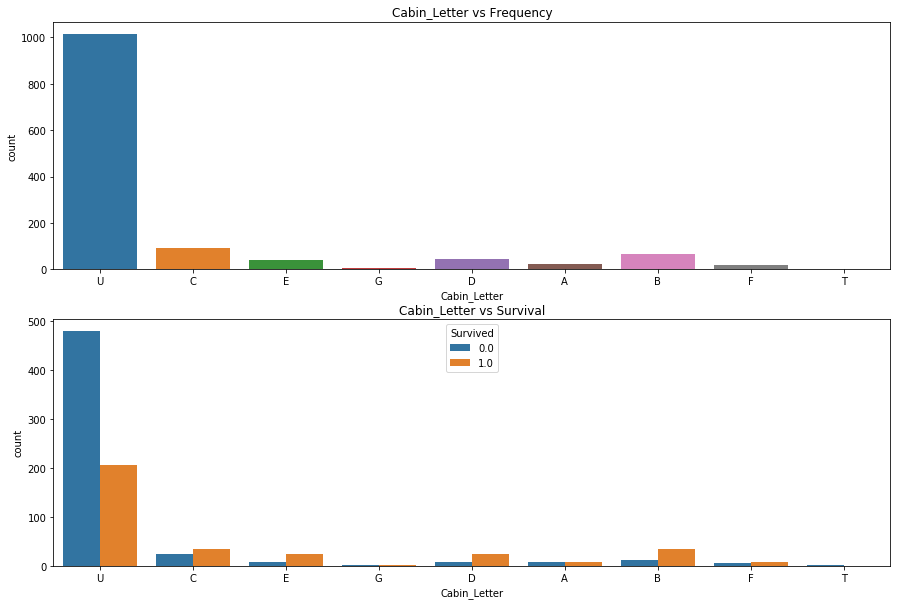

In [146]:
plot_subplots('Cabin_Letter', cabin)

In [147]:
target_columns.append('Cabin_Letter')

In [148]:
full['Cabin_Letter'] = cabin.Cabin_Letter

In [149]:
full.drop(columns='Cabin', inplace=True)

##### Family Size - this is a variable that we can engineer into the data by combining the Siblings and Parent/Children columns. And we can hypothesize that perhaps large families may be able to help each other and survive better

In [150]:
family = pd.DataFrame()

In [151]:
family["FamilySize"] = full.SibSp + full.Parch + 1

In [152]:
family.sample(10)

,FamilySize
177,1
834,1
598,1
824,6
525,1
222,1
275,2
112,1
597,1
780,1


In [153]:
family.describe()

,FamilySize
count,1309.000000
mean,1.883881
std,1.583639
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,11.000000


In [154]:
family.FamilySize.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64

In [155]:
family['Survived'] = full.Survived

Contrary to what we thought, we can see that it will be more likely that a passenger with NO family will be much more likely to die - which makes sense.

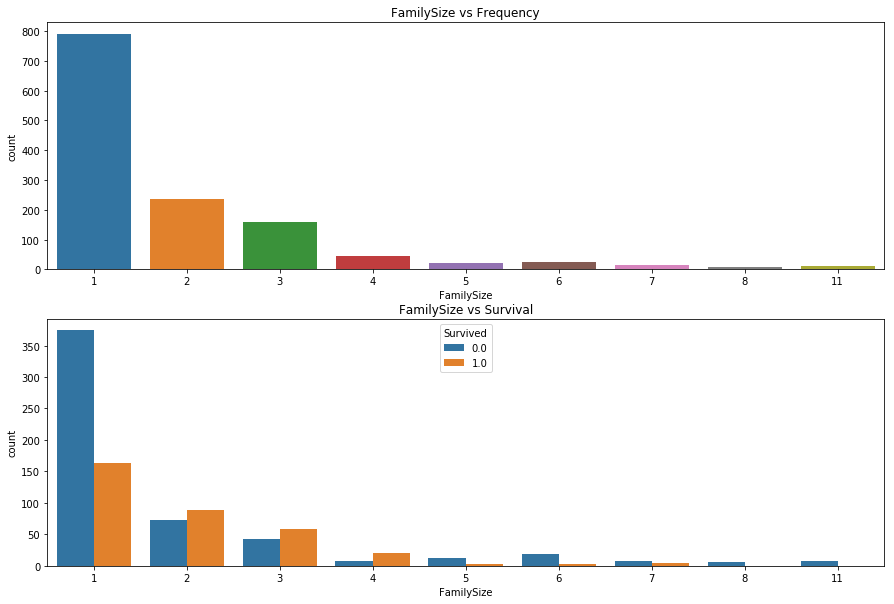

In [156]:
plot_subplots('FamilySize', family)

In [157]:
target_columns.append('FamilySize')

In [158]:
full['FamilySize'] = family.FamilySize

Now let's look at the Fare variable

In [159]:
full[full.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Titles_mapped,Ticket_Count,Cabin_Letter,FamilySize
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,Mr.,Mr,1,U,1


By plotting Title and Embarked vs Fare, we can see that using the 2 variables to impute the missing value for Fare should be rather sufficient

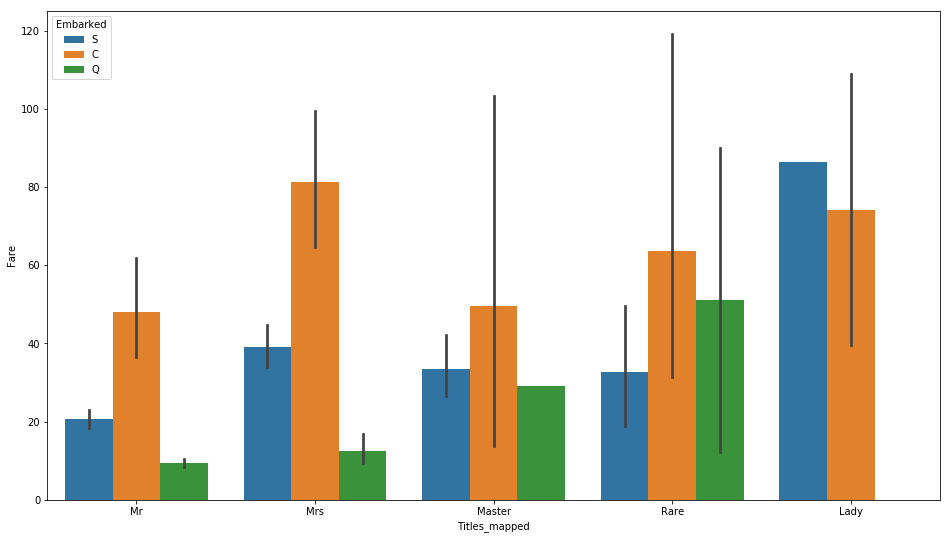

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(x='Titles_mapped', y='Fare', data=full, hue="Embarked")

In [161]:
Mr_S_Fare_Mean = full[(full['Titles_mapped']=='Mr') & (full['Embarked']=='S')]['Fare'].mean()

In [162]:
Mr_S_Fare_Mean

20.584400178253098

In [163]:
full.loc[full.PassengerId==1044,'Fare'] = Mr_S_Fare_Mean

In [164]:
target_columns.append('Fare')

In [165]:
target_columns

['Titles_mapped', 'Ticket_Count', 'Cabin_Letter', 'FamilySize', 'Fare']

By looking at the data for Fare, we can also observe that there are duplicate Fare values. Maybe this has to do with the Ticket duplicates?

In [166]:
full.Fare.value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
10.5000    35
7.7750     26
7.2292     24
7.9250     23
26.5500    22
8.6625     21
7.8542     21
7.2250     21
7.2500     18
0.0000     17
21.0000    14
9.5000     12
16.1000    12
14.5000    11
69.5500    11
27.7208    11
7.7958     10
14.4542    10
7.8792     10
15.5000    10
24.1500     9
15.2458     9
7.0500      9
56.4958     8
46.9000     8
           ..
9.3250      1
9.2167      1
7.5792      1
26.2833     1
7.7792      1
7.2833      1
42.5000     1
34.0208     1
31.6833     1
45.5000     1
25.5875     1
7.7292      1
9.8458      1
7.7208      1
7.8000      1
26.3875     1
15.5792     1
8.6542      1
12.6500     1
40.1250     1
10.5167     1
34.6542     1
27.4458     1
7.5750      1
25.7417     1
8.1375      1
8.1583      1
8.0292      1
12.7375     1
7.1417      1
Name: Fare, Length: 282, dtype: int64

In [167]:
full.sort_values('Ticket').head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Titles_mapped,Ticket_Count,Cabin_Letter,FamilySize
504,505,1.0,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.50,S,Miss.,Mrs,3,B,1
257,258,1.0,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.50,S,Miss.,Mrs,3,B,1
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.50,S,Countess,Lady,3,B,1
585,586,1.0,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,S,Miss.,Mrs,3,E,3
262,263,0.0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,S,Mr.,Mr,3,E,3
558,559,1.0,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,S,Mrs.,Mrs,3,E,3
110,111,0.0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.00,S,Mr.,Mr,2,C,1
475,476,0.0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.00,S,Mr.,Mr,2,A,1
335,1227,NaN,1,"Maguire, Mr. John Edward",male,30.0,0,0,110469,26.00,S,Mr.,Mr,1,C,1
158,1050,NaN,1,"Borebank, Mr. John James",male,42.0,0,0,110489,26.55,S,Mr.,Mr,1,D,1


As shown above, seems like the same Ticket holders have a grouped Fare amount in the Fare variable. We can adjust it to Fare per person by dividing with the Ticket_Count variable we created earlier.

In [168]:
target_columns.remove('Fare')

In [169]:
full['Fare_adjusted'] = full.Fare / full.Ticket_Count

In [170]:
target_columns.append('Fare_adjusted')

Of course, as suggested in the exploring of the Titles variable, it would seem like females have a much higher change of survival

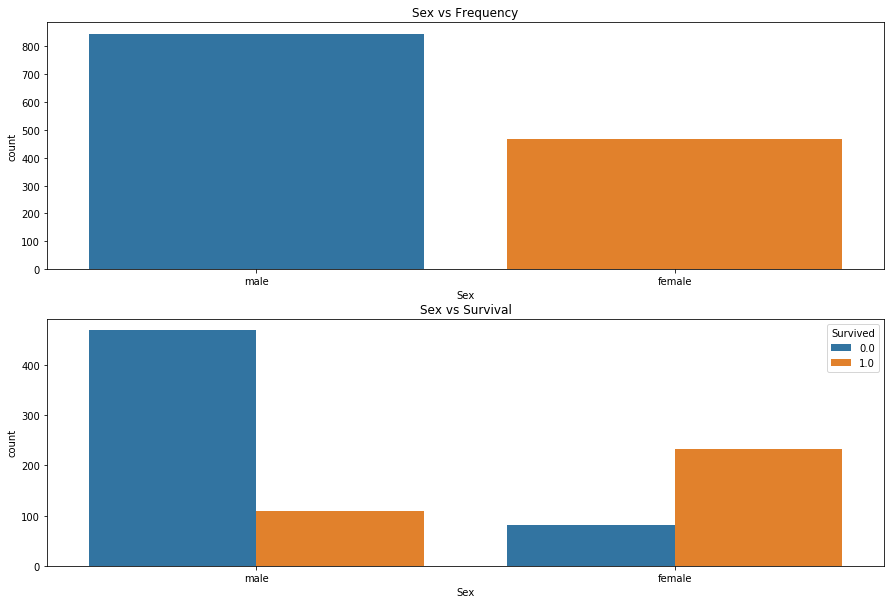

In [171]:
plot_subplots('Sex', full)

In [172]:
target_columns.append('Sex')

In [173]:
full.isnull().sum()

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age              263
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           2
Title              0
Titles_mapped      0
Ticket_Count       0
Cabin_Letter       0
FamilySize         0
Fare_adjusted      0
dtype: int64

We still have a lot of missing data! Let's work on Age. In particular, we can look at the Titles and Passenger Class for more info

In [174]:
full[full.Age.isnull() == False].groupby(['Titles_mapped', 'Pclass']).describe()

Age                                                    \
                      count       mean        std    min     25%   50%    75%   
Titles_mapped Pclass                                                            
Lady          1         3.0  40.000000   7.549834  33.00  36.000  39.0  43.50   
Master        1         5.0   6.984000   4.974061   0.92   4.000   6.0  11.00   
              2        11.0   2.757273   2.723942   0.67   0.915   2.0   3.00   
              3        37.0   6.090000   4.152566   0.33   2.000   6.0   9.00   
Mr            1       132.0  41.450758  13.489020  17.00  30.000  41.5  50.00   
              2       137.0  32.346715  11.862038  14.00  24.000  30.0  38.00   
              3       312.0  28.318910   9.907858  11.00  21.000  26.0  33.00   
Mrs           1       129.0  36.875969  14.416249   2.00  24.000  35.0  48.00   
              2       103.0  27.499223  12.911747   0.92  20.000  28.0  34.00   
              3       152.0  22.185329  12.205254   0.17  16.000  22.0  30.00   
Rare          1        15.0  49.200000   9.213344  32.00  44.500  49.0  53.00   
              2        10.0  40.700000  12.927576  23.00  28.500  41.5  53.25   

                           FamilySize            ...  Survived       \
                       max      count      mean  ...       75%  max   
Titles_mapped Pclass                             ...                  
Lady          1       48.0        3.0  1.333333  ...       1.0  1.0   
Master        1       13.0        5.0  3.800000  ...       1.0  1.0   
              2        8.0       11.0  3.090909  ...       1.0  1.0   
              3       14.5       37.0  4.972973  ...       1.0  1.0   
Mr            1       80.0      132.0  1.659091  ...       1.0  1.0   
              2       70.0      137.0  1.452555  ...       0.0  1.0   
              3       74.0      312.0  1.394231  ...       0.0  1.0   
Mrs           1       76.0      129.0  2.085271  ...       1.0  1.0   
              2       60.0      103.0  2.184466  ...       1.0  1.0   
              3       63.0      152.0  2.532895  ...       1.0  1.0   
Rare          1       70.0       15.0  1.666667  ...       1.0  1.0   
              2       57.0       10.0  1.400000  ...       0.0  0.0   

                     Ticket_Count                                           \
                            count      mean       std  min  25%  50%   75%   
Titles_mapped Pclass                                                         
Lady          1               3.0  2.333333  1.154701  1.0  2.0  3.0  3.00   
Master        1               5.0  5.000000  1.581139  3.0  4.0  5.0  6.00   
              2              11.0  3.090909  0.539360  2.0  3.0  3.0  3.00   
              3              37.0  5.027027  2.327212  1.0  3.0  6.0  7.00   
Mr            1             132.0  2.015152  1.289919  1.0  1.0  2.0  2.00   
              2             137.0  1.802920  1.469491  1.0  1.0  1.0  2.00   
              3             312.0  1.474359  1.332014  1.0  1.0  1.0  1.00   
Mrs           1             129.0  3.023256  1.553550  1.0  2.0  3.0  4.00   
              2             103.0  2.126214  1.081752  1.0  1.0  2.0  3.00   
              3             152.0  2.401316  1.895480  1.0  1.0  2.0  3.00   
Rare          1              15.0  1.733333  1.162919  1.0  1.0  1.0  2.00   
              2              10.0  1.400000  0.699206  1.0  1.0  1.0  1.75   

                            
                       max  
Titles_mapped Pclass        
Lady          1        3.0  
Master        1        7.0  
              2        4.0  
              3       11.0  
Mr            1        7.0  
              2        7.0  
              3        8.0  
Mrs           1        7.0  
              2        5.0  
              3        8.0  
Rare          1        5.0  
              2        3.0  

[12 rows x 72 columns]

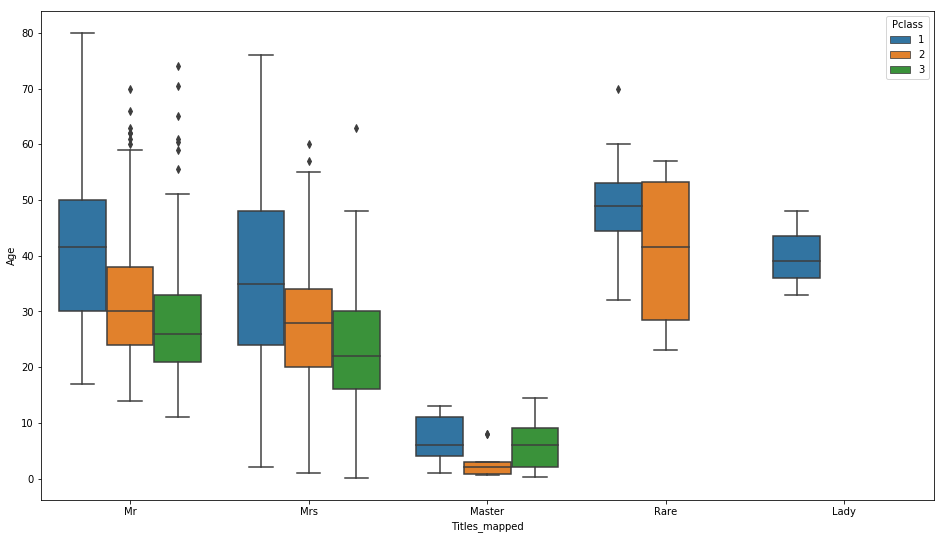

In [175]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.boxplot(x='Titles_mapped', y='Age', data=full, hue="Pclass")

Evidently, further separating by passenger class will give better estimates of the missing Age values.

In [176]:
full[full.Age.isnull()].groupby(['Titles_mapped', 'Pclass']).describe()

Age                              FamilySize            \
                     count mean std min 25% 50% 75% max      count      mean   
Titles_mapped Pclass                                                           
Master        3        0.0  NaN NaN NaN NaN NaN NaN NaN        8.0  4.125000   
Mr            1        0.0  NaN NaN NaN NaN NaN NaN NaN       27.0  1.000000   
              2        0.0  NaN NaN NaN NaN NaN NaN NaN       13.0  1.000000   
              3        0.0  NaN NaN NaN NaN NaN NaN NaN      136.0  1.463235   
Mrs           1        0.0  NaN NaN NaN NaN NaN NaN NaN       11.0  1.636364   
              2        0.0  NaN NaN NaN NaN NaN NaN NaN        3.0  1.000000   
              3        0.0  NaN NaN NaN NaN NaN NaN NaN       64.0  2.500000   
Rare          1        0.0  NaN NaN NaN NaN NaN NaN NaN        1.0  1.000000   

                      ...  Survived      Ticket_Count                      \
                      ...       75%  max        count      mean       std   
Titles_mapped Pclass  ...                                                   
Master        3       ...      1.00  1.0          8.0  4.125000  2.997022   
Mr            1       ...      0.25  1.0         27.0  1.444444  0.974022   
              2       ...      0.00  1.0         13.0  1.461538  0.877058   
              3       ...      0.00  1.0        136.0  1.691176  2.063850   
Mrs           1       ...      1.00  1.0         11.0  2.090909  0.831209   
              2       ...      1.00  1.0          3.0  2.000000  1.000000   
              3       ...      1.00  1.0         64.0  2.515625  2.742911   
Rare          1       ...      0.00  0.0          1.0  1.000000       NaN   

                                                 
                      min  25%  50%   75%   max  
Titles_mapped Pclass                             
Master        3       1.0  3.0  3.0  4.25  11.0  
Mr            1       1.0  1.0  1.0  1.50   5.0  
              2       1.0  1.0  1.0  1.00   3.0  
              3       1.0  1.0  1.0  1.00  11.0  
Mrs           1       1.0  2.0  2.0  2.00   4.0  
              2       1.0  1.5  2.0  2.50   3.0  
              3       1.0  1.0  1.0  3.00  11.0  
Rare          1       1.0  1.0  1.0  1.00   1.0  

[8 rows x 72 columns]

In [177]:
def get_Age_mean(title, pclass):
    return full.loc[(full.Age.isnull() == False) & (full.Titles_mapped==title) & (full.Pclass == pclass)].Age.mean()

In [178]:
get_Age_mean('Master', 3)

6.090000000000001

In [179]:
full.loc[(full.Age.isnull()) & (full.Titles_mapped == 'Master'), 'Age'] = get_Age_mean('Master', 3)

In [180]:
for pclass in [1,2,3]:
    full.loc[(full.Age.isnull()) & (full.Titles_mapped == 'Mr'), 'Age'] = get_Age_mean('Mr', pclass)

In [181]:
for pclass in [1,2,3]:
    full.loc[(full.Age.isnull()) & (full.Titles_mapped == 'Mrs'), 'Age'] = get_Age_mean('Mrs', pclass)

In [182]:
full.loc[(full.Age.isnull()) & (full.Titles_mapped == 'Rare'), 'Age'] = get_Age_mean('Rare', 1)

In [183]:
target_columns.append('Age')

In [184]:
full[full.Age.isnull() == False].groupby(['Titles_mapped', 'Pclass']).describe()

Age                                                  \
                      count       mean        std    min     25%        50%   
Titles_mapped Pclass                                                          
Lady          1         3.0  40.000000   7.549834  33.00  36.000  39.000000   
Master        1         5.0   6.984000   4.974061   0.92   4.000   6.000000   
              2        11.0   2.757273   2.723942   0.67   0.915   2.000000   
              3        45.0   6.090000   3.756137   0.33   3.000   6.090000   
Mr            1       159.0  41.450758  12.282521  17.00  32.750  41.450758   
              2       150.0  33.135732  11.620505  14.00  24.250  31.000000   
              3       448.0  32.305364  10.239040  11.00  23.000  32.000000   
Mrs           1       140.0  36.875969  13.834067   2.00  25.000  36.437984   
              2       106.0  27.764603  12.821504   0.92  20.250  28.000000   
              3       216.0  26.538111  12.240586   0.17  18.000  28.000000   
Rare          1        16.0  49.200000   8.900936  32.00  44.750  49.100000   
              2        10.0  40.700000  12.927576  23.00  28.500  41.500000   

                                      FamilySize            ...  Survived  \
                            75%   max      count      mean  ...       75%   
Titles_mapped Pclass                                        ...             
Lady          1       43.500000  48.0        3.0  1.333333  ...       1.0   
Master        1       11.000000  13.0        5.0  3.800000  ...       1.0   
              2        3.000000   8.0       11.0  3.090909  ...       1.0   
              3        9.000000  14.5       45.0  4.822222  ...       1.0   
Mr            1       48.000000  80.0      159.0  1.547170  ...       1.0   
              2       41.450758  70.0      150.0  1.413333  ...       0.0   
              3       41.450758  74.0      448.0  1.415179  ...       0.0   
Mrs           1       47.250000  76.0      140.0  2.050000  ...       1.0   
              2       35.750000  60.0      106.0  2.150943  ...       1.0   
              3       36.875969  63.0      216.0  2.523148  ...       1.0   
Rare          1       53.000000  70.0       16.0  1.625000  ...       1.0   
              2       53.250000  57.0       10.0  1.400000  ...       0.0   

                          Ticket_Count                                     \
                      max        count      mean       std  min  25%  50%   
Titles_mapped Pclass                                                        
Lady          1       1.0          3.0  2.333333  1.154701  1.0  2.0  3.0   
Master        1       1.0          5.0  5.000000  1.581139  3.0  4.0  5.0   
              2       1.0         11.0  3.090909  0.539360  2.0  3.0  3.0   
              3       1.0         45.0  4.866667  2.445776  1.0  3.0  5.0   
Mr            1       1.0        159.0  1.918239  1.257728  1.0  1.0  2.0   
              2       1.0        150.0  1.773333  1.429069  1.0  1.0  1.0   
              3       1.0        448.0  1.540179  1.590855  1.0  1.0  1.0   
Mrs           1       1.0        140.0  2.950000  1.528271  1.0  2.0  2.5   
              2       1.0        106.0  2.122642  1.075288  1.0  1.0  2.0   
              3       1.0        216.0  2.435185  2.175009  1.0  1.0  2.0   
Rare          1       1.0         16.0  1.687500  1.138347  1.0  1.0  1.0   
              2       0.0         10.0  1.400000  0.699206  1.0  1.0  1.0   

                                  
                       75%   max  
Titles_mapped Pclass              
Lady          1       3.00   3.0  
Master        1       6.00   7.0  
              2       3.00   4.0  
              3       7.00  11.0  
Mr            1       2.00   7.0  
              2       2.00   7.0  
              3       1.00  11.0  
Mrs           1       4.00   7.0  
              2       3.00   5.0  
              3       3.00  11.0  
Rare          1       2.00   5.0  
              2       1.75   3.0  



For Embarked, we can just use the mode as it is by far the most common

In [185]:
full.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [186]:
full[full.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Titles_mapped,Ticket_Count,Cabin_Letter,FamilySize,Fare_adjusted
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,Miss.,Mrs,2,B,1,40.0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,Mrs.,Mrs,2,B,1,40.0


In [187]:
full.Embarked.mode()[0]

'S'

In [188]:
full.loc[full.Embarked.isnull(), 'Embarked'] = full.Embarked.mode()[0]

In [189]:
full.loc[full.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Titles_mapped,Ticket_Count,Cabin_Letter,FamilySize,Fare_adjusted


In [190]:
full.isnull().sum()

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           0
Title              0
Titles_mapped      0
Ticket_Count       0
Cabin_Letter       0
FamilySize         0
Fare_adjusted      0
dtype: int64

In [191]:
target_columns.append('Embarked')

In [192]:
target_columns

['Titles_mapped',
 'Ticket_Count',
 'Cabin_Letter',
 'FamilySize',
 'Fare_adjusted',
 'Sex',
 'Age',
 'Embarked']

In [193]:
fullfinal = full[target_columns]

In [194]:
fullfinal['Pclass'] = full.Pclass

C:\Users\tcw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [195]:
fullfinal.dtypes

Titles_mapped     object
Ticket_Count       int64
Cabin_Letter      object
FamilySize         int64
Fare_adjusted    float64
Sex               object
Age              float64
Embarked          object
Pclass             int64
dtype: object

##### Extra feature engineering - credit to S.Xu's kernel - it is likely that Families/Groups would survive/die together, and we can find that out based on their Last Names and Fare

In [196]:
full['Last_Name'] = full['Name'].apply(lambda x :str.split(x,',')[0])

In [197]:
full.Last_Name.sample(10)

128       Peter
795       Otter
336    de Brito
152      Storey
291      Bishop
212      Deacon
588    Gilinski
408     Riordan
498     Allison
712      Taylor
Name: Last_Name, dtype: object

In [274]:
DEFAULT_SURVIVAL_VALUE = 0.5

In [275]:
full['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

In [277]:
for grp, grp_df in full[['Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId', 'Age',]].groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        #found Family group
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                full.loc[full['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                full.loc[full['PassengerId'] == passID, 'Family_Survival'] = 0
print("Number of passengers with family survival information:", full.loc[full['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [278]:
for _, grp_df in full.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival'] == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    full.loc[full['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    full.loc[full['PassengerId'] == passID, 'Family_Survival'] = 0
print("Number of passenger with family/group survival information: " 
      +str(full[full['Family_Survival']!=0.5].shape[0]))

Number of passenger with family/group survival information: 546


In [279]:
full.Family_Survival.describe()

count    1309.000000
mean        0.522918
std         0.322230
min         0.000000
25%         0.500000
50%         0.500000
75%         0.500000
max         1.000000
Name: Family_Survival, dtype: float64

In [203]:
fullfinal['Family_Survival'] = full.Family_Survival

C:\Users\tcw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now that we have our variables, we will need to encode the categorical variables. As one-hot encoding may lead to sparsity which virtually ensures that continuous variables are assigned higher feature importance, we will use label-encoding instead. 
Source: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [204]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = fullfinal.copy()
for i in range(0,X.shape[1]):
    if X.dtypes[i]=='object':
        X[X.columns[i]] = le.fit_transform(X[X.columns[i]])
X.head()

,Titles_mapped,Ticket_Count,Cabin_Letter,FamilySize,Fare_adjusted,Sex,Age,Embarked,Pclass,Family_Survival
0,2,1,8,2,7.25000,1,22.0,2,3,0.5
1,3,2,2,2,35.64165,0,38.0,0,1,0.5
2,3,1,8,1,7.92500,0,26.0,2,3,0.5
3,3,2,2,2,26.55000,0,35.0,2,1,0.0
4,2,1,8,1,8.05000,1,35.0,2,3,0.5


In [230]:
X['Survived'] = full.Survived

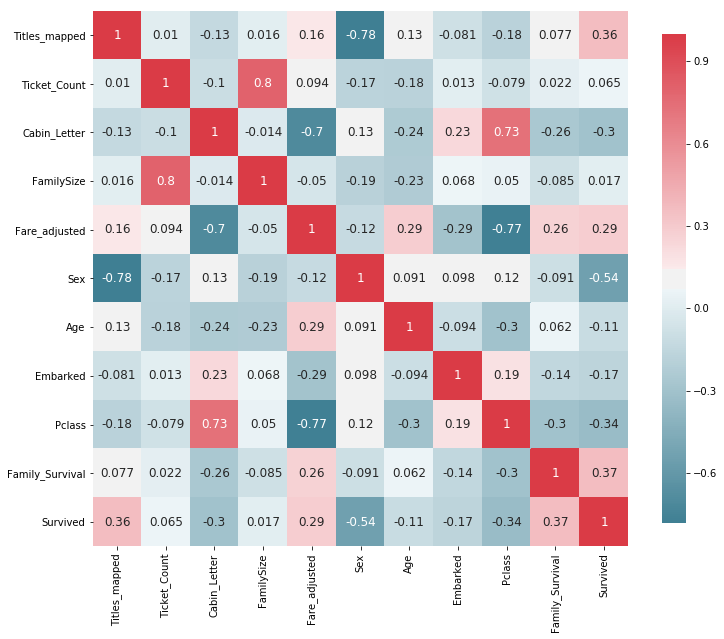

In [231]:
plot_correlation_map(X)

In [206]:
full_bins = fullfinal.copy()

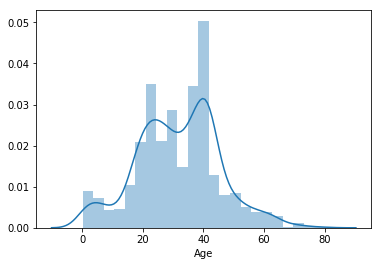

In [207]:
sns.distplot(full_bins.Age)

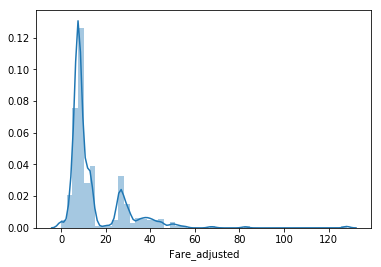

In [208]:
sns.distplot(full_bins.Fare_adjusted)

In [280]:
full_bins['AgeBin'] = pd.qcut(full_bins['Age'], 5)

In [281]:
full_bins['FareBin'] = pd.qcut(full_bins['Fare_adjusted'], 6)

In [282]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [283]:
full_bins['AgeBin_Code'] = label.fit_transform(full_bins.AgeBin)

In [284]:
full_bins['FareBin_Code'] = label.fit_transform(full_bins.FareBin)

In [285]:
full_bins['CabinBin_Code'] = label.fit_transform(full_bins.Cabin_Letter)

In [286]:
full_bins['EmbarkedBin_Code'] = label.fit_transform(full_bins.Embarked)

In [287]:
full_bins.head()

,Titles_mapped,Ticket_Count,Cabin_Letter,FamilySize,Fare_adjusted,Sex,Age,Embarked,Pclass,Family_Survival,AgeBin,FareBin,AgeBin_Code,FareBin_Code,CabinBin_Code,EmbarkedBin_Code
0,Mr,1,U,2,7.25000,male,22.0,S,3,0.5,"(21.0, 28.0]","(7.225, 7.775]",1,1,8,2
1,Mrs,2,C,2,35.64165,female,38.0,C,1,0.5,"(36.876, 41.451]","(26.9, 128.082]",3,5,2,0
2,Mrs,1,U,1,7.92500,female,26.0,S,3,0.5,"(21.0, 28.0]","(7.775, 8.05]",1,2,8,2
3,Mrs,2,C,2,26.55000,female,35.0,S,1,0.0,"(28.0, 36.876]","(13.0, 26.9]",2,4,2,2
4,Mr,1,U,1,8.05000,male,35.0,S,3,0.5,"(28.0, 36.876]","(7.775, 8.05]",2,2,8,2


In [288]:
full_bin_final = full_bins.drop(columns=['Titles_mapped', 'Cabin_Letter','Fare_adjusted', 'Age', 'Embarked', 'AgeBin', 'FareBin'] )

In [289]:
full_bin_final.head()

,Ticket_Count,FamilySize,Sex,Pclass,Family_Survival,AgeBin_Code,FareBin_Code,CabinBin_Code,EmbarkedBin_Code
0,1,2,male,3,0.5,1,1,8,2
1,2,2,female,1,0.5,3,5,2,0
2,1,1,female,3,0.5,1,2,8,2
3,2,2,female,1,0.0,2,4,2,2
4,1,1,male,3,0.5,2,2,8,2


In [290]:
full_bin_final.Sex = label.fit_transform(full_bin_final.Sex)

In [292]:
full_bin_final.head()

,Ticket_Count,FamilySize,Sex,Pclass,Family_Survival,AgeBin_Code,FareBin_Code,CabinBin_Code,EmbarkedBin_Code
0,1,2,1,3,0.5,1,1,8,2
1,2,2,0,1,0.5,3,5,2,0
2,1,1,0,3,0.5,1,2,8,2
3,2,2,0,1,0.0,2,4,2,2
4,1,1,1,3,0.5,2,2,8,2


In [293]:
full_train = full_bin_final.copy()

In [294]:
full_train.describe()

,Ticket_Count,FamilySize,Sex,Pclass,Family_Survival,AgeBin_Code,FareBin_Code,CabinBin_Code,EmbarkedBin_Code
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.101604,1.883881,0.644003,2.294882,0.522918,1.876241,2.399542,6.729565,1.493506
std,1.779832,1.583639,0.478997,0.837836,0.322230,1.389660,1.685983,2.454520,0.814244
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,2.000000,0.500000,1.000000,1.000000,8.000000,1.000000
50%,1.000000,1.000000,1.000000,3.000000,0.500000,2.000000,2.000000,8.000000,2.000000
75%,3.000000,2.000000,1.000000,3.000000,0.500000,3.000000,4.000000,8.000000,2.000000
max,11.000000,11.000000,1.000000,3.000000,1.000000,4.000000,5.000000,8.000000,2.000000


In [222]:
full_train.columns

Index(['Ticket_Count', 'FamilySize', 'Sex', 'Pclass', 'Family_Survival',
       'AgeBin_Code', 'FareBin_Code', 'CabinBin_Code', 'EmbarkedBin_Code'],
      dtype='object')

In [223]:
full_train.dtypes

Ticket_Count          int64
FamilySize            int64
Sex                   int64
Pclass                int64
Family_Survival     float64
AgeBin_Code           int64
FareBin_Code          int64
CabinBin_Code         int64
EmbarkedBin_Code      int64
dtype: object

In [224]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [225]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [226]:
def recover_train_test_target(df):
    global combined
    
    targets = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train = df.iloc[:891]
    test = df.iloc[891:]
    
    return train, test, targets

In [227]:
train, test, targets = recover_train_test_target(full_train)

In [236]:
def checkFeatureImportance(dataset):
    train, test, targets = recover_train_test_target(dataset)
    clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
    clf = clf.fit(train, targets)
    
    features = pd.DataFrame()
    features['feature'] = train.columns
    features['importance'] = clf.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    
    features.plot(kind='barh', figsize=(10, 10))

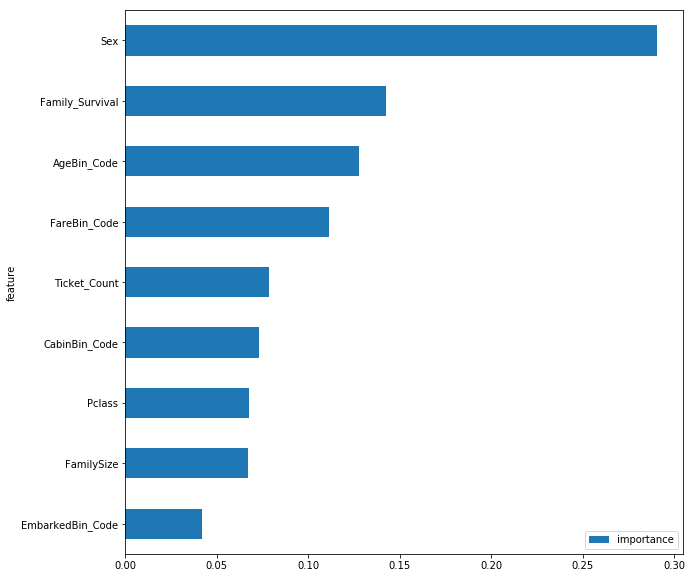

In [295]:
checkFeatureImportance(full_train)

By looking at the feature importance plot above, we can revise the variables that we will chooes for our predictions:

Embarked - as its feature importance is low, and it is unlikely that port of origin should affect survival, we will leave this out.

Cabin - there was a lot of missing data for this variable, so it may be best that we exclude this variable as well

Ticket Count - as we have already included this variable by adjusting Fare with it, we can exclude it

Pclass - we will choose to keep this variable as it should still be an important predictor (high correlation with Survival etc.)

In [244]:
full_train.columns

Index(['Ticket_Count', 'FamilySize', 'Sex', 'Pclass', 'Family_Survival',
       'AgeBin_Code', 'FareBin_Code', 'CabinBin_Code', 'EmbarkedBin_Code'],
      dtype='object')

In [296]:
full_train2 = full_train.drop(columns=['EmbarkedBin_Code', 'CabinBin_Code', 'Ticket_Count'])

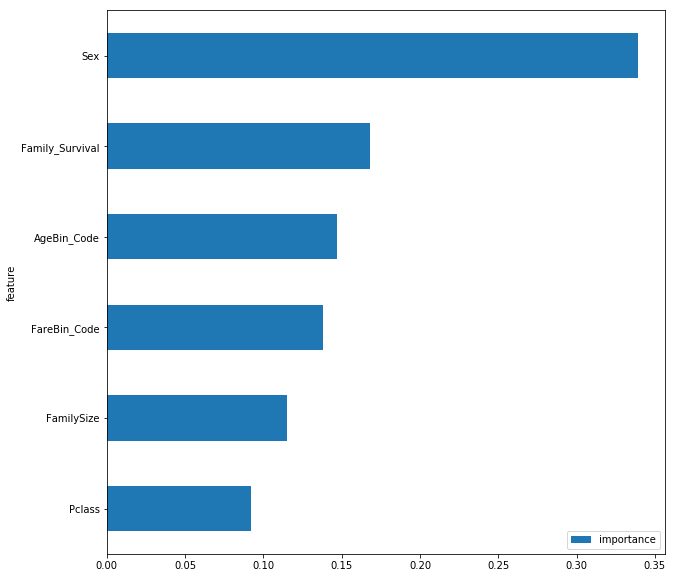

In [297]:
checkFeatureImportance(full_train2)

In [298]:
full_train2.head()

,FamilySize,Sex,Pclass,Family_Survival,AgeBin_Code,FareBin_Code
0,2,1,3,0.5,1,1
1,2,0,1,0.5,3,5
2,1,0,3,0.5,1,2
3,2,0,1,0.0,2,4
4,1,1,3,0.5,2,2


In [299]:
full_train2.describe()

,FamilySize,Sex,Pclass,Family_Survival,AgeBin_Code,FareBin_Code
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,1.883881,0.644003,2.294882,0.522918,1.876241,2.399542
std,1.583639,0.478997,0.837836,0.322230,1.389660,1.685983
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,0.500000,1.000000,1.000000
50%,1.000000,1.000000,3.000000,0.500000,2.000000,2.000000
75%,2.000000,1.000000,3.000000,0.500000,3.000000,4.000000
max,11.000000,1.000000,3.000000,1.000000,4.000000,5.000000


Scale features for better prediction:

In [300]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
train = std_scaler.fit_transform(train)
test = std_scaler.fit_transform(test)

We can use BayesSearch to automate the selection of the best hyperparameters

In [262]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from skopt import BayesSearchCV

# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 20 # 1000
TRAINING_SIZE = 100000 # 20000000
TEST_SIZE = 25000



pipeline = make_pipeline(SelectKBest(), RandomForestClassifier())
parameter_grid = {
                 'selectkbest__k': (3,6),
                 'randomforestclassifier__max_depth' : (6,14),
                 'randomforestclassifier__n_estimators': (40,60),
                 'randomforestclassifier__max_features': ['sqrt', 'auto', 'log2'],
                 'randomforestclassifier__min_samples_split': (0.01, 1.0, 'uniform'),
                 'randomforestclassifier__min_samples_leaf': (0.01, 0.5, 'uniform'),
                 'randomforestclassifier__bootstrap': [True, False],
                 }
    
bayes_cv_tuner = BayesSearchCV(
    estimator = pipeline,
    search_spaces = parameter_grid,    
    scoring = 'accuracy',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=45
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 1,
    refit = True,
    random_state = 45
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [263]:
results = bayes_cv_tuner.fit(train, targets, callback=status_print)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Model #1
Best ROC-AUC: 0.6162
Best params: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 13, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 0.3772785939184296, 'randomforestclassifier__min_samples_split': 0.37965153598535134, 'randomforestclassifier__n_estimators': 60, 'selectkbest__k': 3}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


Model #2
Best ROC-AUC: 0.8238
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.041936752935665664, 'randomforestclassifier__min_samples_split': 0.13835657695217576, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


Model #3
Best ROC-AUC: 0.8238
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.041936752935665664, 'randomforestclassifier__min_samples_split': 0.13835657695217576, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Model #4
Best ROC-AUC: 0.8238
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.041936752935665664, 'randomforestclassifier__min_samples_split': 0.13835657695217576, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Model #5
Best ROC-AUC: 0.8238
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.041936752935665664, 'randomforestclassifier__min_samples_split': 0.13835657695217576, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.3s finished


Model #6
Best ROC-AUC: 0.8238
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.041936752935665664, 'randomforestclassifier__min_samples_split': 0.13835657695217576, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.3s finished


Model #7
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.4s finished


Model #8
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Model #9
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


Model #10
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Model #11
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Model #12
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.5s finished


Model #13
Best ROC-AUC: 0.826
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.020043967494068025, 'randomforestclassifier__min_samples_split': 0.03428371688134219, 'randomforestclassifier__n_estimators': 47, 'selectkbest__k': 4}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Model #14
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Model #15
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


Model #16
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


Model #17
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Model #18
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


Model #19
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


Model #20
Best ROC-AUC: 0.8328
Best params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 0.01, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__n_estimators': 43, 'selectkbest__k': 5}



GridSearchCV to find best parameters:

In [301]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'max_depth' : [8,10,12],
                 'n_estimators': [45,47,48,50],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best score: 0.8518518518518519
Best parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 48}


[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed:  5.8min finished


We can also use KNN, which had yielded better results

In [304]:
from sklearn.neighbors import KNeighborsClassifier 

# turn run_gs to True if you want to run the gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'n_neighbors' : [6,7,8,9,10,11,12,114,16,18,20,22],
                 'algorithm': ['auto'],
                 'weights': ['uniform', 'distance'],
                 'leaf_size': list(range(1,50,5)),
                 }
    KNN = KNeighborsClassifier()
    cross_validation = StratifiedKFold(n_splits=10)

    grid_search = GridSearchCV(KNN,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Best score: 0.8507295173961841
Best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 10, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:  1.4min finished


In [305]:
model

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [6, 7, 8, 9, 10, 11, 12, 114, 16, 18, 20, 22], 'algorithm': ['auto'], 'weights': ['uniform', 'distance'], 'leaf_size': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Export results from best estimator to csv for submitting to Kaggle.

In [250]:
def to_Kaggle_csv(model, filename):
    output = model.predict(test).astype(int)
    df_output = pd.DataFrame()
    aux = pd.read_csv('test.csv')
    df_output['PassengerId'] = aux['PassengerId']
    df_output['Survived'] = output
    df_output[['PassengerId','Survived']].to_csv(filename, index=False)

In [306]:
to_Kaggle_csv(model, 'Family_Survival_KNN_GridSearch.csv')

## Score - 0.81339